### Imports

In [1]:
import argparse
import os.path as osp

import torch
import torch.nn.functional as F
from torch.nn import Linear, LazyLinear, Sequential, BatchNorm1d, ReLU

import torch_geometric.transforms as T
from torch_geometric.datasets import MovieLens
from torch_geometric.nn import SAGEConv, to_hetero, LightGCN

import pathlib
import os
import sys
parent_path = pathlib.Path(os.getcwd()).parent.absolute()
sys.path.append(str(parent_path))
from utils.Neo4jMovieLensMetaData import Neo4jMovieLensMetaData
from utils.gnn_simple import Model
from utils.visualize import plot_loss, plot_test

import matplotlib.pyplot as plt


/Users/ioannisathanasiou/diploma/environ/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

path = osp.join(osp.dirname(osp.abspath('')), '../../data/MovieLensNeo4jMetaData')
dataset = Neo4jMovieLensMetaData(
    path,
    model_name='all-MiniLM-L6-v2',
    database_url="bolt://localhost:7687",
    database_username="neo4j",
    database_password="admin",
    force_pre_process=True,
    force_db_restore=False,
    text_features=["title", "original_title"],
    list_features=[],
    fastRP_features=[],
    numeric_features=[],
    node2vec_features=[],
    SAGE_features=[],
)

# path = osp.join('../../data/MovieLens')
# dataset = MovieLens(path, model_name='all-MiniLM-L6-v2')
data = dataset[0].to(device)

data = dataset[0].to(device)
# Add user node features for message passing:
data['user'].x = torch.eye(data['user'].num_nodes, device=device)
del data['user'].num_nodes
# Add a reverse ('movie', 'rev_rates', 'user') relation for message passing:
data = T.ToUndirected()(data)
del data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)

Processing...


Movies have features...
Encoding title...


Batches: 100%|██████████| 565/565 [00:16<00:00, 34.23it/s]


Encoding original_title...


Batches: 100%|██████████| 565/565 [00:22<00:00, 25.38it/s]


[torch.Size([18062, 384]), torch.Size([18062, 384])]


Done!


### Train test functions

In [5]:
latest_predictions = []
losses_ = {}

def train_test(model, use_weighted_loss, epochs):


    with torch.no_grad():
        model(train_data.edge_index_dict[('user', 'rates', 'movie')])

    optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

    weight = torch.bincount(train_data['user', 'movie'].edge_label)
    weight = weight.max() / weight

    def weighted_rmse_loss(pred, target, weight=None):
        weight = 1. if weight is None else weight[target].to(pred.dtype)
        return (weight * (pred - target.to(pred.dtype)).pow(2)).mean()

    def train(log=False):
        model.train()
        optimizer.zero_grad()
        pred = model(train_data.edge_index_dict[('user', 'rates', 'movie')], train_data[('user', 'rates', 'movie')].edge_label_index)
        # print(pred[:10])
        target = train_data['user', 'movie'].edge_label

        loss = weighted_rmse_loss(pred, target, weight)
        loss.backward()
        optimizer.step()
        return float(loss)

    @torch.no_grad()
    def test(data, log=False):
        global latest_predictions
        model.eval()
        pred = model(data.edge_index_dict[('user', 'rates', 'movie')], data[('user', 'rates', 'movie')].edge_label_index)
        # print(pred[:10])
        pred = pred.clamp(min=0, max=5)
        latest_predictions = pred
        target = data['user', 'movie'].edge_label.float()
        rmse = F.mse_loss(pred, target).sqrt()
        return float(rmse)
    
    losses = []
    for epoch in range(1, epochs+1):
        loss = train(log=not(epoch%20))
        train_rmse = test(train_data)
        val_rmse = test(val_data)
        test_rmse = test(test_data, log=not(epoch%20))
        losses.append((loss, train_rmse, val_rmse, test_rmse))
        # if not epoch % 5:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
            f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')
        # if epoch > 50 and early_stopper.early_stop(val_rmse):
        #     print("Early stopping...")
        #     break

    last_losses = losses[-1]
    losses = losses + [last_losses] * (epochs - len(losses))
    losses_["LIGHT"] = losses

### Experiments

In [18]:
model = LightGCN(num_nodes=data.num_nodes, embedding_dim=128, num_layers=3)
train_test(model, use_weighted_loss=True, epochs=300)

Epoch: 001, Loss: 21.0966, Train: 2.8732, Val: 2.8729, Test: 2.7834
Epoch: 002, Loss: 19.7226, Train: 3.5833, Val: 3.5824, Test: 3.5072
Epoch: 003, Loss: 20.0298, Train: 3.6549, Val: 3.6539, Test: 3.6735
Epoch: 004, Loss: 20.8815, Train: 3.3894, Val: 3.3891, Test: 3.5081
Epoch: 005, Loss: 18.1825, Train: 2.9259, Val: 2.9255, Test: 3.0393
Epoch: 006, Loss: 19.2805, Train: 2.9203, Val: 2.9199, Test: 3.0171
Epoch: 007, Loss: 19.2593, Train: 3.1782, Val: 3.1780, Test: 3.2606
Epoch: 008, Loss: 16.8953, Train: 3.3811, Val: 3.3808, Test: 3.4353
Epoch: 009, Loss: 18.0083, Train: 3.4555, Val: 3.4549, Test: 3.4778
Epoch: 010, Loss: 18.6768, Train: 3.4276, Val: 3.4272, Test: 3.4158
Epoch: 011, Loss: 18.3624, Train: 3.3037, Val: 3.3037, Test: 3.2496
Epoch: 012, Loss: 17.2061, Train: 3.1009, Val: 3.1010, Test: 3.0043
Epoch: 013, Loss: 16.1238, Train: 2.9109, Val: 2.9109, Test: 2.7783
Epoch: 014, Loss: 17.0019, Train: 2.8844, Val: 2.8845, Test: 2.7177
Epoch: 015, Loss: 16.9795, Train: 3.0026, Val: 3

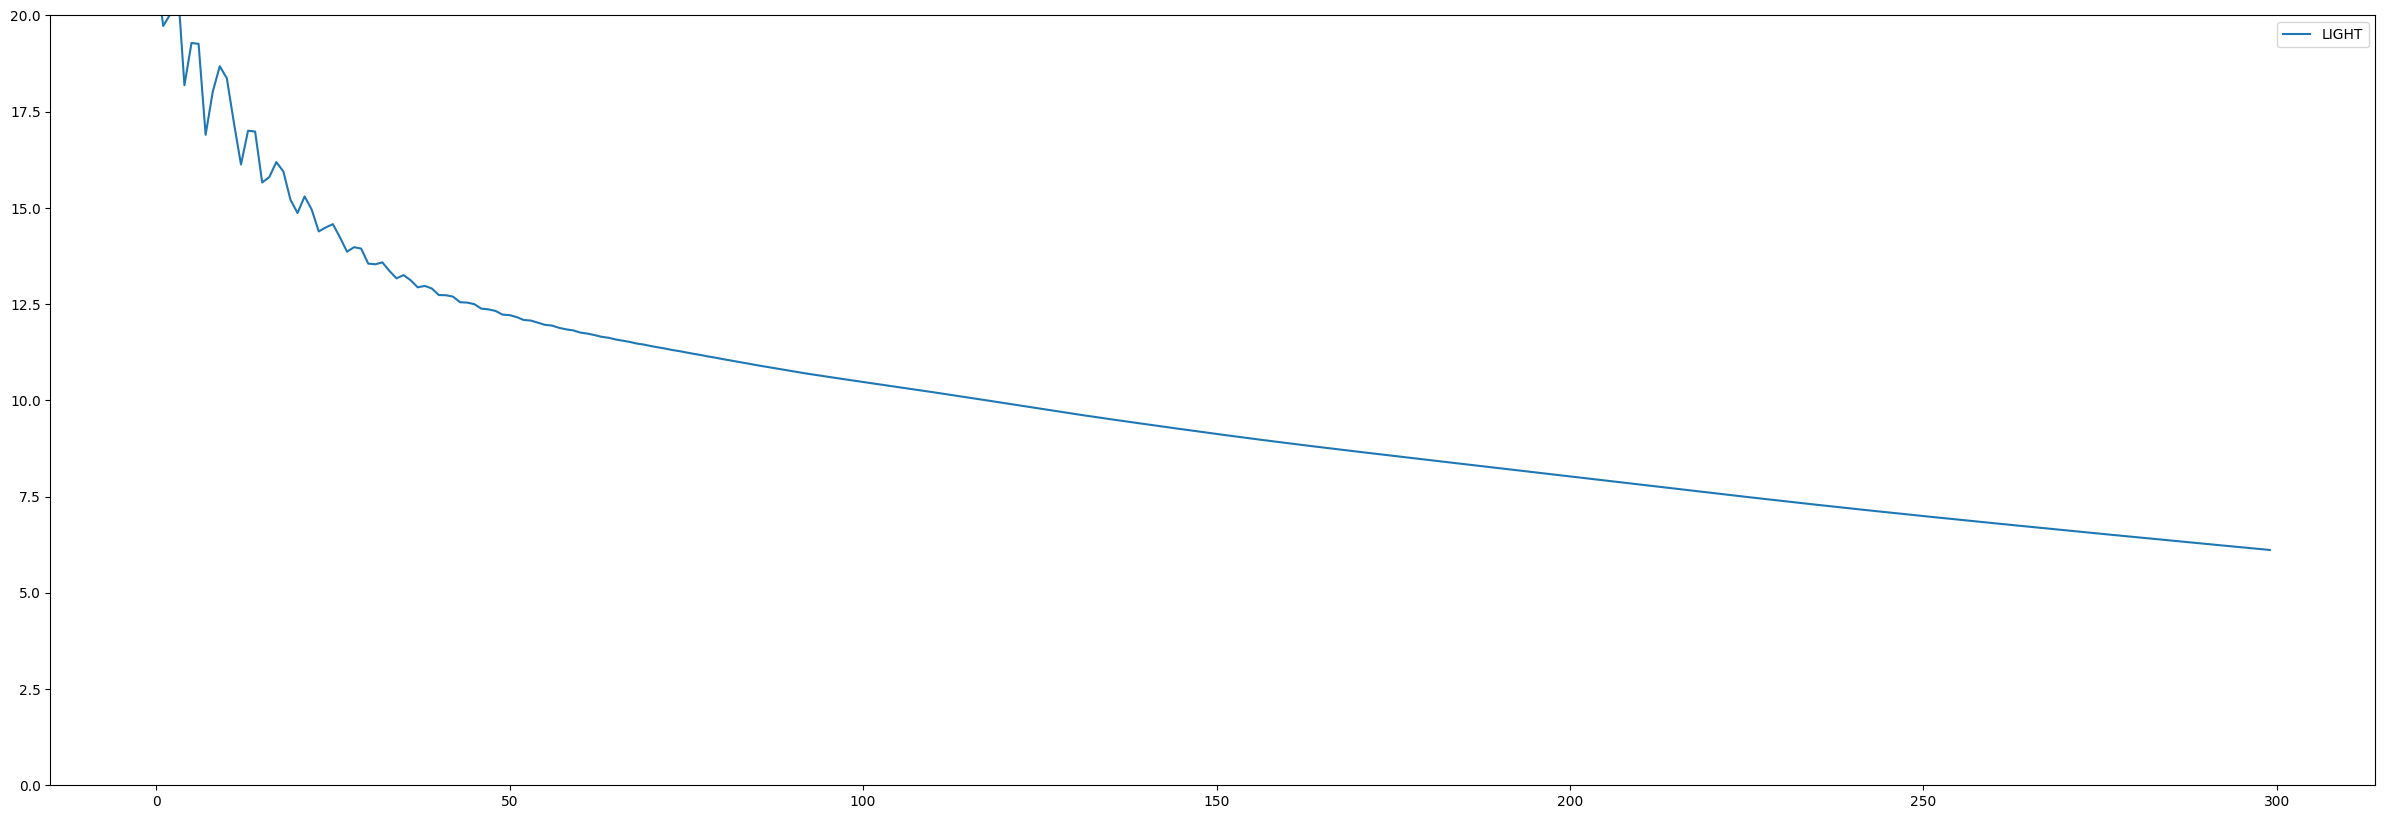

In [19]:
plot_loss(losses_, ylim=20)

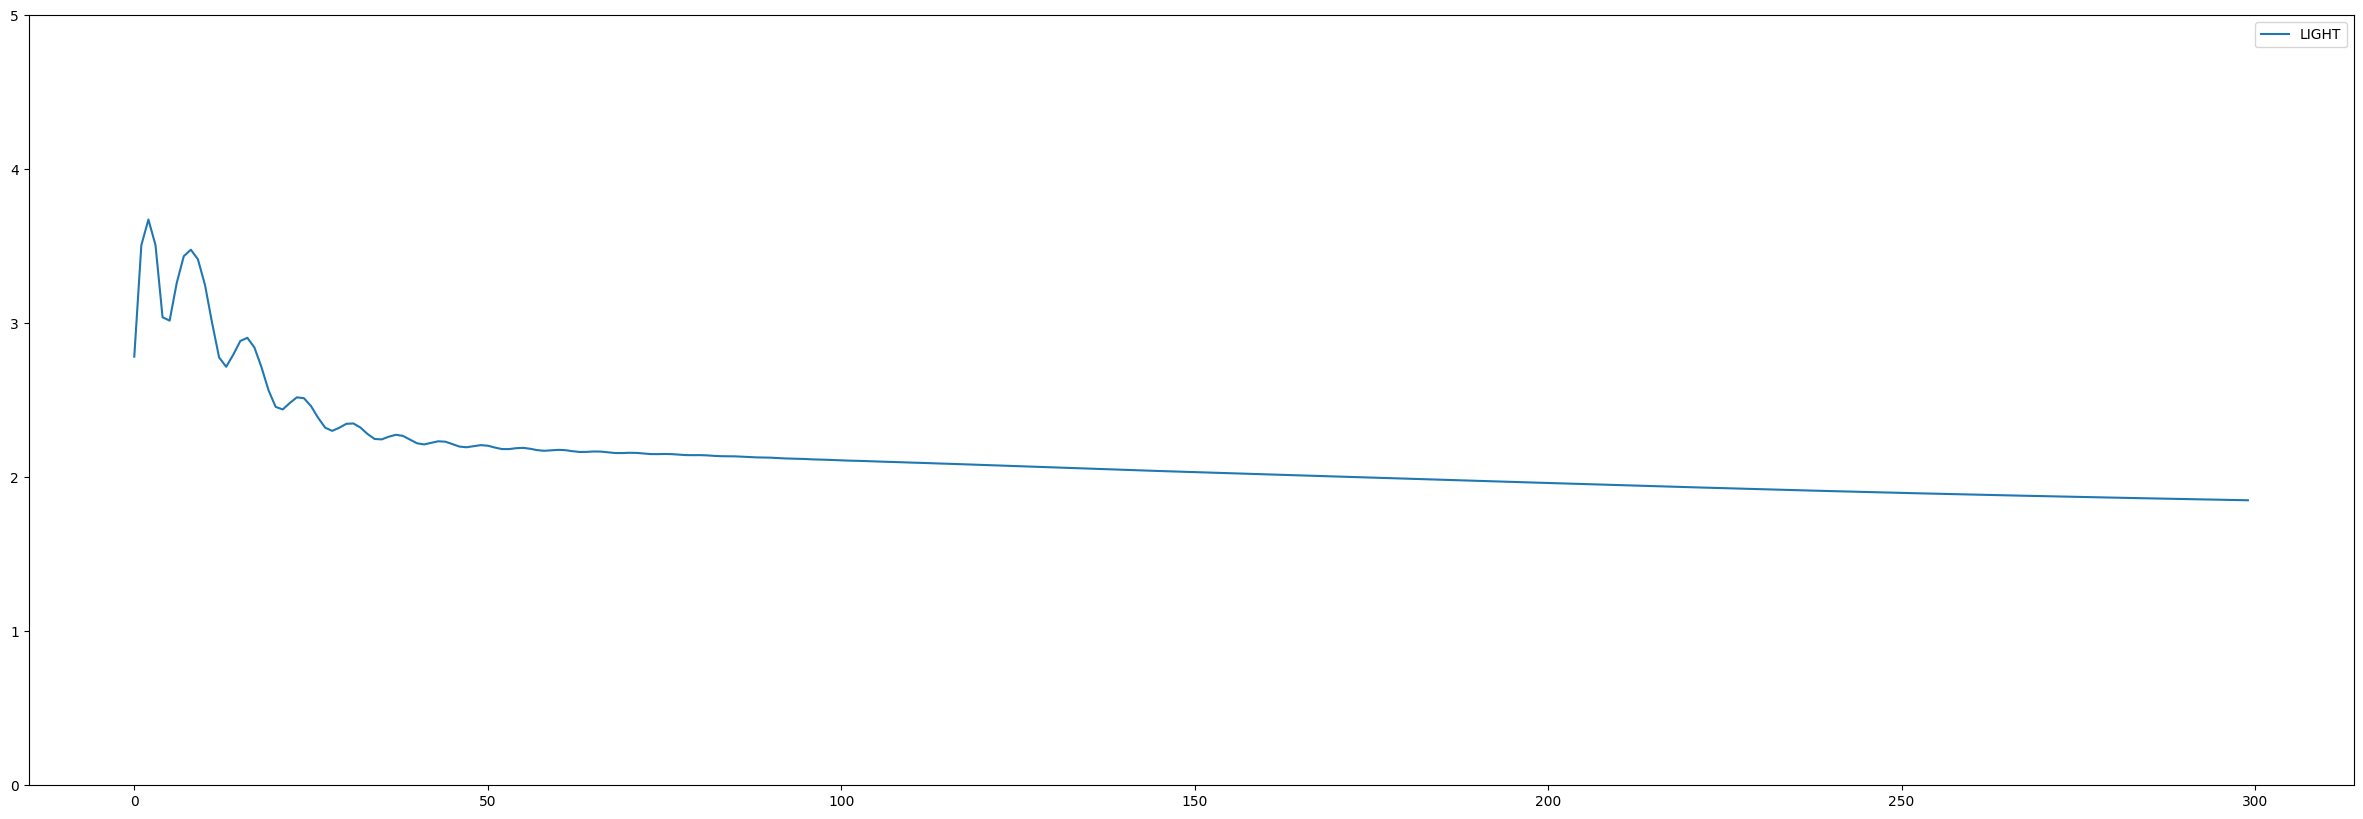

In [20]:
plot_test(losses_, ylim=5)

(array([ 14661.,   5641.,   7281.,   8182.,   8685.,   8918.,   9063.,
          8658.,   8571., 186419.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

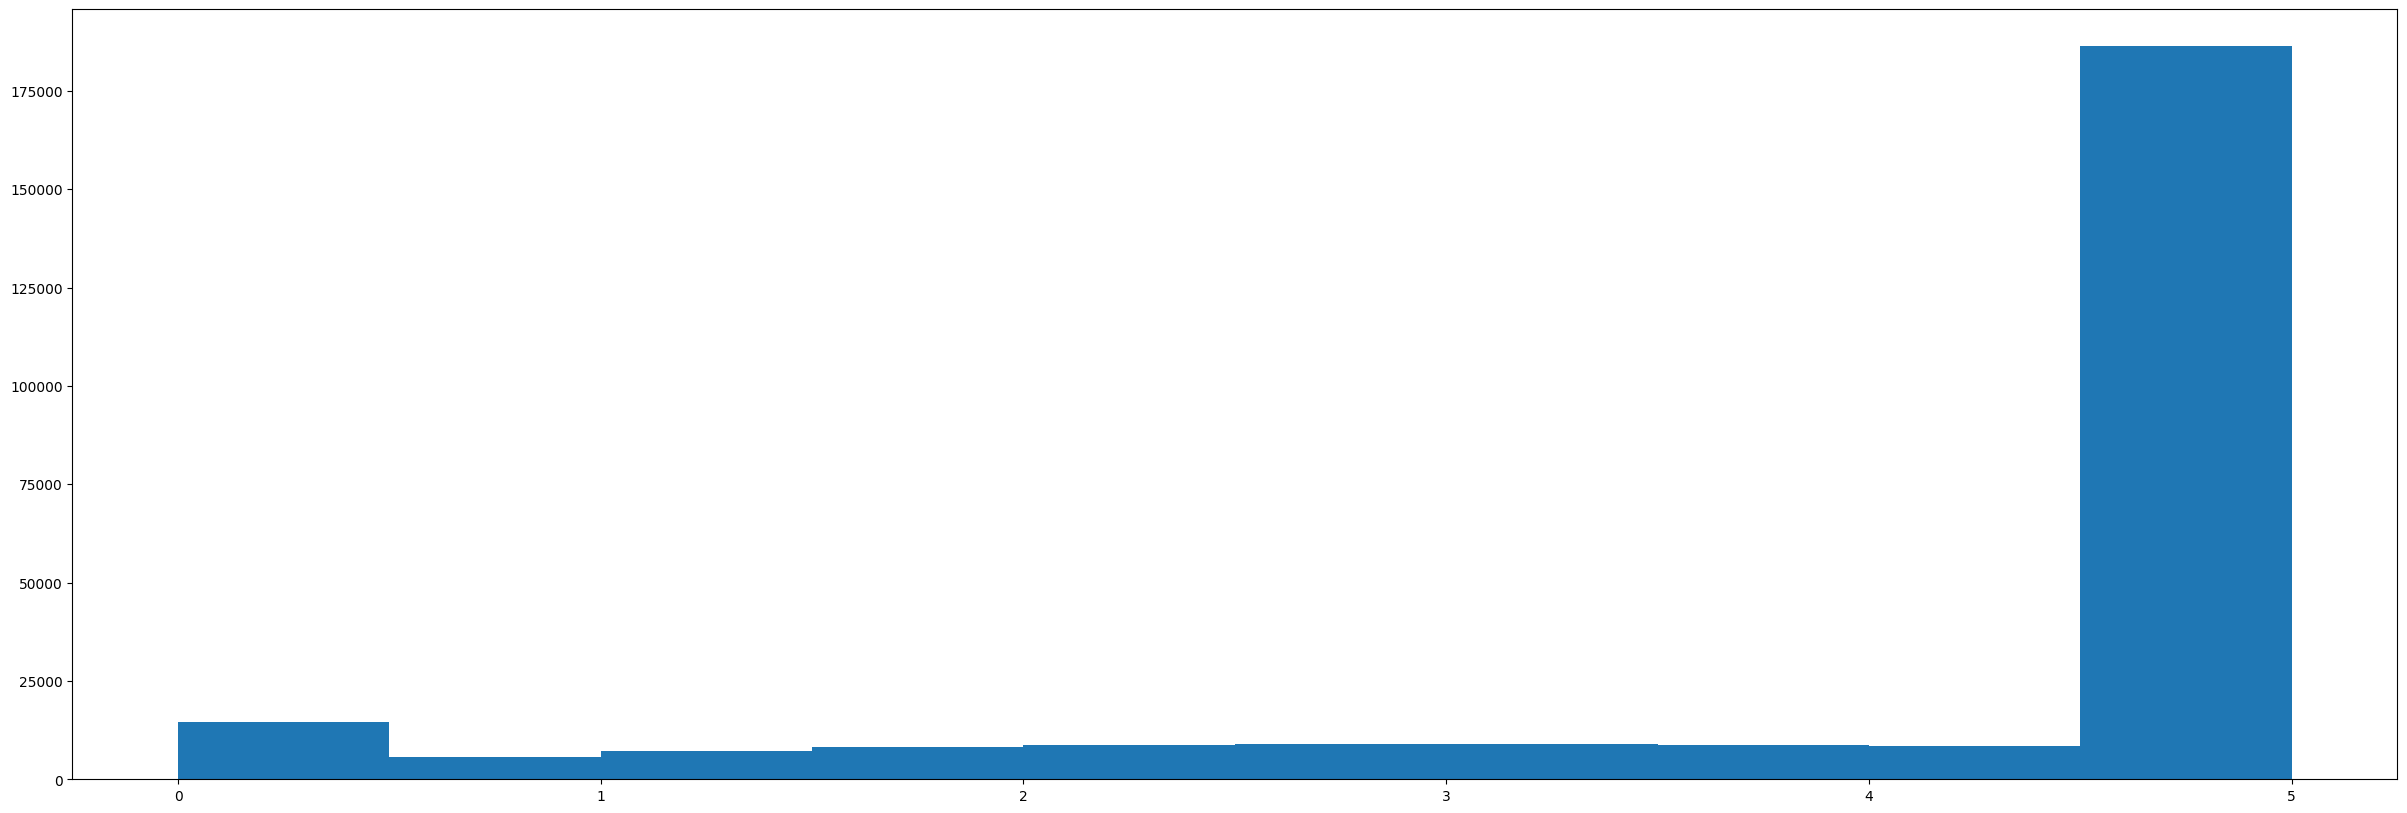

In [21]:
plt.hist(latest_predictions)

### Tests

In [14]:
edge_index = data[("user", "rates", "movie")].edge_index
recs = model.recommend(edge_index, k=10)
recs.shape

torch.Size([34298, 10])

In [15]:
recs

tensor([[  350,   291,  2410,  ...,  1133,   108,   577],
        [  350,   291,  2410,  ...,  1133,   108,   577],
        [  350,   291,  2410,  ...,  1133,   108,   577],
        ...,
        [34295, 19055, 19192,  ..., 20377, 33620, 26885],
        [34296, 33666, 25404,  ..., 18655, 26064, 27284],
        [34297, 32773, 19267,  ..., 20235, 23506, 25496]])

In [22]:
pred = model(train_data.edge_index_dict[('user', 'rates', 'movie')])

(array([3.010000e+02, 3.161810e+05, 1.581803e+06, 2.165700e+05,
        1.076500e+04, 2.228000e+03, 5.570000e+02, 1.770000e+02,
        3.800000e+01, 1.200000e+01]),
 array([-5.26954365, -2.15619659,  0.95715064,  4.07049799,  7.18384504,
        10.29719162, 13.41053963, 16.52388573, 19.63723373, 22.75057983,
        25.86392784]),
 <BarContainer object of 10 artists>)

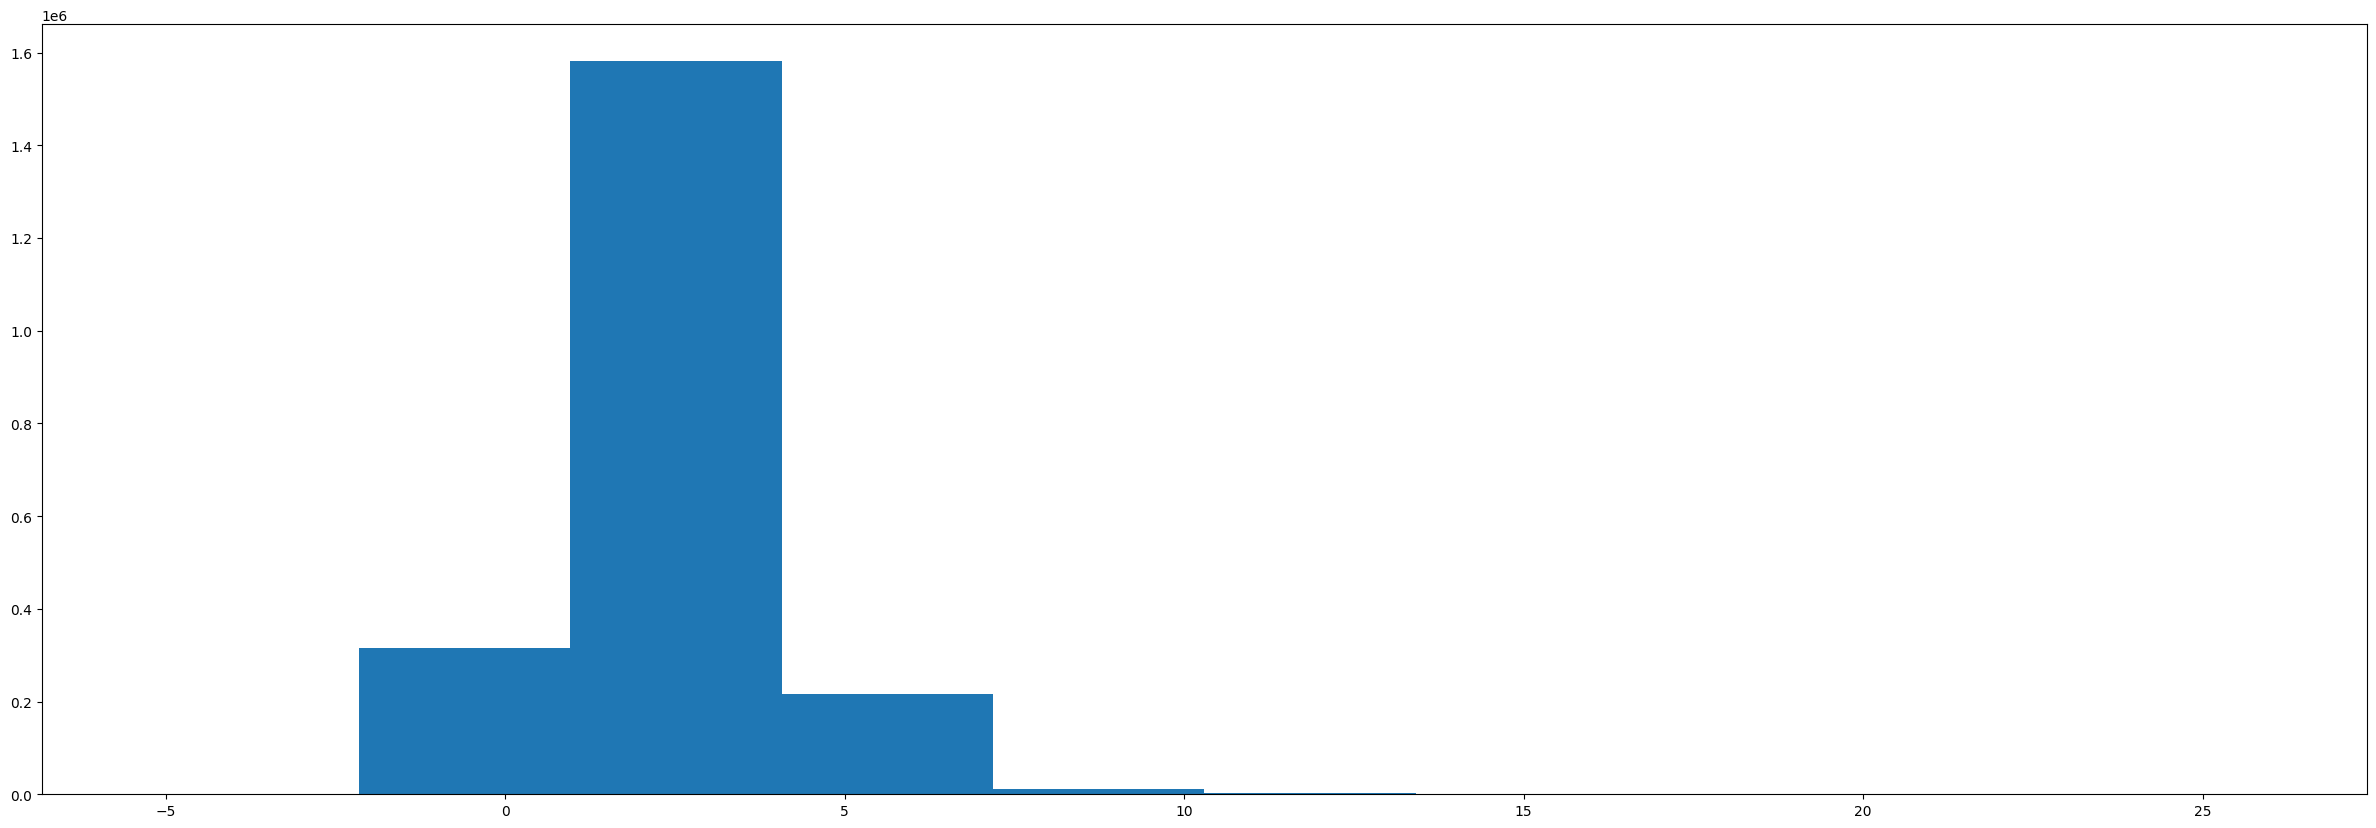

In [23]:
import matplotlib.pyplot as plt
predictions = pred.detach().numpy()
plt.hist(predictions)